In [15]:
import argparse

import torch
import torch.nn as nn

import matplotlib.pyplot as plt

from EANN import *

In [2]:
# Get default arguments

parse = argparse.ArgumentParser()
parser = parse_arguments(parse)

train = ''
test = ''
output = '../Data/weibo/RESULT/'
args = parser.parse_args([train, test, output])

In [3]:
# Load data

train, validation, test, W = load_data(args)

Text and image


Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\Purva\AppData\Local\Temp\jieba.cache


image length 13274


Loading model cost 0.841 seconds.
Prefix dict has been built successfully.


Original post length is 5415
Original data frame is (5415, 6)
Label number is 5415
Rummor number is 2898
Non rummor is 2517
data size is 5415
paired post length is 5415
paried data has 8 dimension
Original post length is 843
Original data frame is (843, 6)
Label number is 843
Rummor number is 454
Non rummor is 389
data size is 843
paired post length is 843
paried data has 8 dimension
Original post length is 1465
Original data frame is (1465, 6)
Label number is 1465
Rummor number is 756
Non rummor is 709
data size is 1465
paired post length is 1465
paried data has 8 dimension
loading data...
number of sentences: 7723
vocab size: 4626
max sentence length: 316
word2vec loaded!
num words already in word2vec: 4626
word2vec loaded!
num words already in word2vec: 4626
translate data to embedding
translate test data to embedding
sequence length 28
Train Data Size is 5415
Finished loading data 


In [4]:
# Prepare dataloader

test_dataset = Rumor_Data(test)

test_loader = DataLoader(dataset=test_dataset,
                             batch_size=args.batch_size,
                             shuffle=False)

TEXT: 1465, Image: 1465, labe: 1465, Event: 1465


In [7]:
# Best model
best_validate_dir = '../data/weibo/RESULT/15.pkl'

# Load model for evaluation
model = CNN_Fusion(args, W)
model.load_state_dict(torch.load(best_validate_dir))

if torch.cuda.is_available():
    model.cuda()

model.eval()

test_score = []
test_pred = []
test_true = []

In [8]:
# Run the evaluation

for i, (test_data, test_labels, event_labels) in enumerate(test_loader):
    test_text, test_image, test_mask, test_labels = to_var(
        test_data[0]), to_var(test_data[1]), to_var(test_data[2]), to_var(test_labels)
    test_outputs, domain_outputs= model(test_text, test_image, test_mask)
    _, test_argmax = torch.max(test_outputs, 1)
    if i == 0:
        test_score = to_np(test_outputs.squeeze())
        test_pred = to_np(test_argmax.squeeze())
        test_true = to_np(test_labels.squeeze())
    else:
        test_score = np.concatenate((test_score, to_np(test_outputs.squeeze())), axis=0)
        test_pred = np.concatenate((test_pred, to_np(test_argmax.squeeze())), axis=0)
        test_true = np.concatenate((test_true, to_np(test_labels.squeeze())), axis=0)

test_accuracy = metrics.accuracy_score(test_true, test_pred)
test_f1 = metrics.f1_score(test_true, test_pred, average='macro')
test_precision = metrics.precision_score(test_true, test_pred, average='macro')
test_recall = metrics.recall_score(test_true, test_pred, average='macro')
test_score_convert = [x[1] for x in test_score]
test_aucroc = metrics.roc_auc_score(test_true, test_score_convert, average='macro')

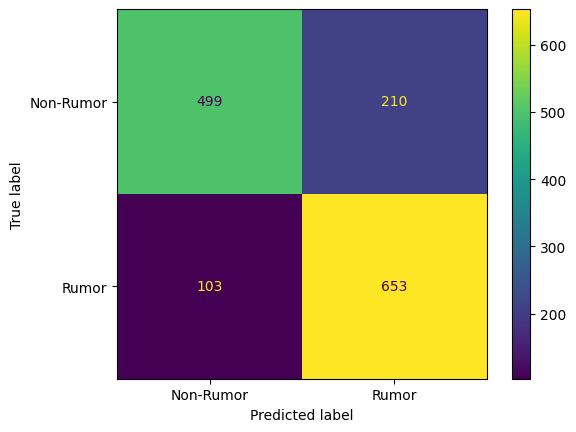

In [20]:
metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(test_true, test_pred), display_labels=['Non-Rumor', 'Rumor']).plot()

In [9]:
true_positives = []
true_negatives = []
false_positives = []
false_negatives = []


# Get indexes of all the types in the test data
for i in range(len(test_score)):
    if test_pred[i] == test_true[i]:
        if test_true[i] == 0:
            true_negatives.append(i)
        else:
            true_positives.append(i)
    else:
        if test_true[i] == 0:
            false_positives.append(i)
        else:
            false_negatives.append(i)

In [16]:
# Get word embeddings

word_vector_path = '../Data/weibo/word_embedding.pickle'
f = open(word_vector_path, 'rb')
weight = pickle.load(f)  # W, W2, word_idx_map, vocab
W, W2, word_idx_map, vocab, max_len = weight[0], weight[1], weight[2], weight[3], weight[4]

# Invert mapping
idx_word_map = {v: k for k, v in word_idx_map.items()}

idx_word_map[0] = ''

def visualize(idx):
    plt.imshow(test_loader.dataset.image[idx].permute(1, 2, 0))
    plt.axis('off')
    for w in test_loader.dataset.text[idx]:
        # print(w.item())
        print(idx_word_map[w.item()], end="")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


有人 传言 保罗 没 死 真如 传言 所说 权威 报道 不负 负责 责任 不负责任 传言 可信 信度 可信度 传言 提供 照片 中 看得 得出 看得出 保罗 黑眼 眼睛 黑眼睛 保罗 明明 眼睛 蓝眼睛 有人 给出 答案 新浪 娱乐 央视 新闻 新闻 晨报 新闻晨报

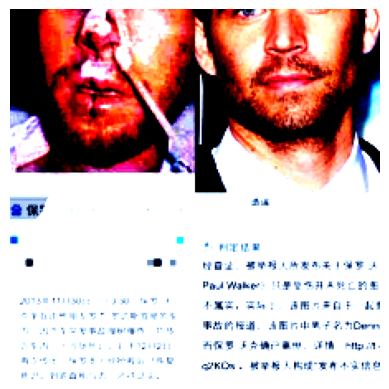

In [65]:
visualize(false_negatives[5])

In [18]:
test_true[0]

0

In [19]:
test_pred[0]

0